# Fetch and export SNOTEL sites and daily time series data
2/29/2020

In [1]:
from collections import OrderedDict

import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import geometry as sgeom
import ulmo
import json

import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
########## USER ###########
# Select modeling domain ('WY', 'UT', 'OR', 'WA','HJA','CA')
domain = 'HJA'

# # Select the files you want (1=True, 0=False)
# # metadata for SNOTEL stations within you domain 
# SNOTELmeta = 1

# # SWE depth [m] data for SNOTEL stations within you domain over modeling timespan
# SWEdata = 1

# # Snow depth [m] data for SNOTEL stations within you domain over modeling timespan
# SNODdata = 1

In [19]:
# Outfile path
outpath = '/nfs/attic/dfh/Aragon2/CSOdata/'+domain+'/'

#path to CSO domain json
with open('/nfs/attic/dfh/Aragon2/CSOdata/CSO_domains.json') as f:
    domains = json.load(f)

#start date    
st = domains[domain]['st']
#end date
ed = domains[domain]['ed']

#Snotel bounding box
Bbox = domains[domain]['Bbox']

# Snotel projection
stn_proj = domains[domain]['stn_proj']
# model projection
mod_proj = domains[domain]['mod_proj']

In [20]:
# Can enter manually if you do not have a JSON from the DomainParams_2JSON Notebook

# ##USER INPUTS## - most of this can be read directly from the .ctl file or the .par file 
# #-> need to read in text file
# #start date
# st = "2014-10-01"
# #end date
# ed = "2019-09-29"


# #Snotel bounding box
# Bbox = {
#     'latmax' : 44.582480,
#     'latmin' : 42.363116,
#     'lonmax': -109.477849,
#     'lonmin': -111.155208,}

# # Snotel projection
# stn_proj = 'epsg:4326' #WGS84
# #model projection
# mod_proj = 'epsg:32612' #UTM zone 12N

# Use ulmo to get SNOTEL station metadata within bounding box
## Get SNOTEL metadata over modeling domain

In [21]:
#function to extract data
def sites_asgdf(ulmo_getsites, crs=stn_proj):
    """ Convert ulmo.cuahsi.wof.get_sites response into a point GeoDataframe
    """
    
    # Note: Found one SNOTEL site that was missing the location key
    sites_df = pd.DataFrame.from_records([
        OrderedDict(code=s['code'], 
        longitude=float(s['location']['longitude']), 
        latitude=float(s['location']['latitude']), 
        name=s['name'], 
        elevation_m=s['elevation_m'])
        for _,s in ulmo_getsites.items()
        if 'location' in s
    ])

    sites_gdf = gpd.GeoDataFrame(
        sites_df, 
        geometry=gpd.points_from_xy(sites_df['longitude'], sites_df['latitude']),
        crs=crs
    )
    return sites_gdf

In [22]:
# Convert the bounding box dictionary to a shapely Polygon geometry using sgeom.box
box_sgeom = sgeom.box(Bbox['lonmin'], Bbox['latmin'], Bbox['lonmax'], Bbox['latmax'])
box_gdf = gpd.GeoDataFrame(geometry=[box_sgeom], crs=stn_proj)

In [23]:
# WaterML/WOF WSDL endpoint url 
wsdlurl = "http://hydroportal.cuahsi.org/Snotel/cuahsi_1_1.asmx?WSDL"

# get dictionary of snotel sites 
sites = ulmo.cuahsi.wof.get_sites(wsdlurl,user_cache=True)

#turn sites as geodataframe 
snotel_gdf = sites_asgdf(sites)

In [24]:
CSO_gdf = gpd.sjoin(snotel_gdf, box_gdf, how="inner")
CSO_gdf.drop(columns='index_right', inplace=True)
CSO_gdf.reset_index(drop=True, inplace=True)
#CSO_gdf.index = CSO_gdf['code']

#add columns with projected coordinates 
CSO_proj = CSO_gdf.to_crs(mod_proj)
CSO_gdf['easting'] = CSO_proj.geometry.x
CSO_gdf['northing'] = CSO_proj.geometry.y

CSO_gdf.head()

,code,longitude,latitude,name,elevation_m,geometry,easting,northing


## Visualize station locations

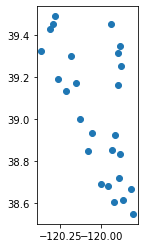

In [9]:
CSO_gdf.plot();

# Get SNOTEL SWE data in domain, over time period of interest

In [10]:
def fetch(sitecode, variablecode, start_date, end_date):
    print(sitecode, variablecode, start_date, end_date)
    values_df = None
    try:
        #Request data from the server
        site_values = ulmo.cuahsi.wof.get_values(
            wsdlurl, 'SNOTEL:'+sitecode, variablecode, start=start_date, end=end_date
        )
        #Convert to a Pandas DataFrame   
        values_df = pd.DataFrame.from_dict(site_values['values'])
        #Parse the datetime values to Pandas Timestamp objects
        values_df['datetime'] = pd.to_datetime(values_df['datetime'])
        #Set the DataFrame index to the Timestamps
        values_df.set_index('datetime', inplace=True)
        #Convert values to float and replace -9999 nodata values with NaN
        values_df['value'] = pd.to_numeric(values_df['value']).replace(-9999, np.nan)
        #Remove any records flagged with lower quality
        values_df = values_df[values_df['quality_control_level_code'] == '1']
    except:
        print("Unable to fetch %s" % variablecode)
    
    return values_df

In [11]:
stn_swe = pd.DataFrame(index=pd.date_range(start=st, end=ed))

for sitecode in CSO_gdf.code:
    try:
        swe = fetch(sitecode, variablecode='SNOTEL:WTEQ_D', start_date=st, end_date=ed)
        #check for nan values
        if len(swe.value[np.isnan(swe.value)]) > 0:
            #check if more than 10% of data is missing
            if len(swe.value[np.isnan(swe.value)])/len(swe) > .1:
                print('More than 10% of days missing')
                CSO_gdf.drop(CSO_gdf.loc[CSO_gdf['code']==sitecode].index, inplace=True)
                continue
        stn_swe[sitecode] = swe.value
    except:
        CSO_gdf.drop(CSO_gdf.loc[CSO_gdf['code']==sitecode].index, inplace=True)

340_NV_SNTL SNOTEL:WTEQ_D 2014-09-01 2019-09-30
356_CA_SNTL SNOTEL:WTEQ_D 2014-09-01 2019-09-30
1051_CA_SNTL SNOTEL:WTEQ_D 2014-09-01 2019-09-30
1067_CA_SNTL SNOTEL:WTEQ_D 2014-09-01 2019-09-30
428_CA_SNTL SNOTEL:WTEQ_D 2014-09-01 2019-09-30
462_CA_SNTL SNOTEL:WTEQ_D 2014-09-01 2019-09-30
463_CA_SNTL SNOTEL:WTEQ_D 2014-09-01 2019-09-30
473_CA_SNTL SNOTEL:WTEQ_D 2014-09-01 2019-09-30
1049_CA_SNTL SNOTEL:WTEQ_D 2014-09-01 2019-09-30
508_CA_SNTL SNOTEL:WTEQ_D 2014-09-01 2019-09-30
518_CA_SNTL SNOTEL:WTEQ_D 2014-09-01 2019-09-30
1050_CA_SNTL SNOTEL:WTEQ_D 2014-09-01 2019-09-30
539_CA_SNTL SNOTEL:WTEQ_D 2014-09-01 2019-09-30
540_CA_SNTL SNOTEL:WTEQ_D 2014-09-01 2019-09-30
541_CA_SNTL SNOTEL:WTEQ_D 2014-09-01 2019-09-30
1242_NV_SNTL SNOTEL:WTEQ_D 2014-09-01 2019-09-30
615_NV_SNTL SNOTEL:WTEQ_D 2014-09-01 2019-09-30
652_NV_SNTL SNOTEL:WTEQ_D 2014-09-01 2019-09-30
258_NV_SNTL SNOTEL:WTEQ_D 2014-09-01 2019-09-30


Unable to fetch SNOTEL:WTEQ_D
724_CA_SNTL SNOTEL:WTEQ_D 2014-09-01 2019-09-30
778_CA_SNTL SNOTEL:WTEQ_D 2014-09-01 2019-09-30
784_CA_SNTL SNOTEL:WTEQ_D 2014-09-01 2019-09-30
809_CA_SNTL SNOTEL:WTEQ_D 2014-09-01 2019-09-30
834_CA_SNTL SNOTEL:WTEQ_D 2014-09-01 2019-09-30
848_CA_SNTL SNOTEL:WTEQ_D 2014-09-01 2019-09-30
246_CA_SNTL SNOTEL:WTEQ_D 2014-09-01 2019-09-30


Unable to fetch SNOTEL:WTEQ_D


In [12]:
stn_swe.head()

,340_NV_SNTL,356_CA_SNTL,1051_CA_SNTL,1067_CA_SNTL,428_CA_SNTL,462_CA_SNTL,463_CA_SNTL,473_CA_SNTL,1049_CA_SNTL,508_CA_SNTL,...,541_CA_SNTL,1242_NV_SNTL,615_NV_SNTL,652_NV_SNTL,724_CA_SNTL,778_CA_SNTL,784_CA_SNTL,809_CA_SNTL,834_CA_SNTL,848_CA_SNTL
2014-09-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-09-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-09-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-09-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-09-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
#convert SNOTEL units[in] to SnowModel units [m]
for sitecode in CSO_gdf.code:
    # overwrite the original values (no use for the original values in inches)
    stn_swe[sitecode] = 0.0254 * stn_swe[sitecode]

stn_swe.head()

,340_NV_SNTL,356_CA_SNTL,1051_CA_SNTL,1067_CA_SNTL,428_CA_SNTL,462_CA_SNTL,463_CA_SNTL,473_CA_SNTL,1049_CA_SNTL,508_CA_SNTL,...,541_CA_SNTL,1242_NV_SNTL,615_NV_SNTL,652_NV_SNTL,724_CA_SNTL,778_CA_SNTL,784_CA_SNTL,809_CA_SNTL,834_CA_SNTL,848_CA_SNTL
2014-09-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-09-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-09-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-09-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-09-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
ndf = pd.DataFrame(stn_swe['314_WY_SNTL'])
data =

## Export the sites to files, for reuse
- CSO_gdf to GeoJSON

**Note:** Sometimes the statement below produces this warning:
```
CSO_SNOTEL_sites.geojson: No such file or directory 
driver GeoJSON does not support creation option ENCODING
```

Ignore it. The GeoJSON file is still written out without issues.

In [14]:
out = outpath + 'CSO_SNOTEL_sites.geojson'
CSO_gdf.to_file(out, driver='GeoJSON')

## Export the daily time series to files, for reuse
- stn_swe to csv

In [15]:
# The file that's written is tiny, only 0.5 MB
out = outpath + 'CSO_SNOTEL_data_SWEDmeters.csv'
stn_swe.to_csv(out)

# Get SNOTEL snow depth data in domain, over time period of interest

In [73]:
stn_snod = pd.DataFrame(index=pd.date_range(start=st, end=ed))

for sitecode in CSO_gdf.code:
    try:
        swe = fetch(sitecode, variablecode='SNOTEL:SNOD_D', start_date=st, end_date=ed)
        #check for nan values
        if len(swe.value[np.isnan(swe.value)]) > 0:
            #check if more than 10% of data is missing
            if len(swe.value[np.isnan(swe.value)])/len(swe) > .1:
                print('More than 10% of days missing')
                CSO_gdf.drop(CSO_gdf.loc[CSO_gdf['code']==sitecode].index, inplace=True)
                continue
        stn_snod[sitecode] = swe.value
    except:
        CSO_gdf.drop(CSO_gdf.loc[CSO_gdf['code']==sitecode].index, inplace=True)

1166_OR_SNTL SNOTEL:SNOD_D 2014-09-01 2019-09-30


Unable to fetch SNOTEL:SNOD_D
434_OR_SNTL SNOTEL:SNOD_D 2014-09-01 2019-09-30
Unable to fetch SNOTEL:SNOD_D
526_OR_SNTL SNOTEL:SNOD_D 2014-09-01 2019-09-30


Unable to fetch SNOTEL:SNOD_D
545_OR_SNTL SNOTEL:SNOD_D 2014-09-01 2019-09-30
Unable to fetch SNOTEL:SNOD_D
614_OR_SNTL SNOTEL:SNOD_D 2014-09-01 2019-09-30


Unable to fetch SNOTEL:SNOD_D
619_OR_SNTL SNOTEL:SNOD_D 2014-09-01 2019-09-30
Unable to fetch SNOTEL:SNOD_D
719_OR_SNTL SNOTEL:SNOD_D 2014-09-01 2019-09-30


Unable to fetch SNOTEL:SNOD_D
733_OR_SNTL SNOTEL:SNOD_D 2014-09-01 2019-09-30
Unable to fetch SNOTEL:SNOD_D
1167_OR_SNTL SNOTEL:SNOD_D 2014-09-01 2019-09-30


Unable to fetch SNOTEL:SNOD_D
815_OR_SNTL SNOTEL:SNOD_D 2014-09-01 2019-09-30
Unable to fetch SNOTEL:SNOD_D


In [ ]:
stn_snod.head()

In [ ]:
#convert SNOTEL units[in] to SnowModel units [m]
for sitecode in CSO_gdf.code:
    # overwrite the original values (no use for the original values in inches)
    stn_snod[sitecode] = 0.0254 * stn_snod[sitecode]

stn_swe.head()

## Export the daily time series to files, for reuse
- stn_swe to csv

In [ ]:
out = outpath + 'CSO_SNOTEL_data_SNODmeters.csv'
stn_snod.to_csv(out)

## Remove outliers using mahalanobis distance

In [29]:
# function to compute Mahalanobis Distance
from scipy import linalg

def mahalanobis(x=None, data=None, cov=None):
    """Compute the Mahalanobis Distance between each row of x and the data  
    x    : vector or matrix of data with, say, p columns.
    data : ndarray of the distribution from which Mahalanobis distance of each observation of x is to be computed.
    cov  : covariance matrix (p x p) of the distribution. If None, will be computed from data.
    """
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()



In [15]:
for sitecode in CSO_gdf.code:
    ndf = pd.DataFrame(stn_swe[sitecode])
    ndf['mahala'] = mahalanobis(x=ndf, data=ndf[sitecode])

KeyError: 0

In [ ]:
# this code can be used to fill nan values in the SNOTEL data

# def ranges(nums):
#     nums = sorted(set(nums))
#     gaps = [[s, e] for s, e in zip(nums, nums[1:]) if s+1 < e]
#     edges = iter(nums[:1] + sum(gaps, []) + nums[-1:])
#     return list(zip(edges, edges))

#             #fill in nan values
#             f = np.where(np.isnan(swe.value))
#             l=np.shape(f)[1]
#             consec = ranges(f[0])
#             for i in range(np.shape(consec)[0]):
#                 st_bound = consec[i][0]
#                 ed_bound = consec[i][1]
#                 st_swe = swe.value[st_bound-1]
#                 ed_swe = swe.value[ed_bound+1]
#                 fill = (ed_swe-st_swe)/l
#                 for n in range(l):
#                     swe.value[f[0][n]]=st_swe+fill*(n+1)        